In [4]:
import os
import rasterio.merge
import rioxarray as rxr
from rasterio.plot import show
from rasterio.mask import mask
from tqdm import tqdm
import matplotlib.pyplot as plt

from shapely import geometry
import fiona

import numpy as np
from descartes import PolygonPatch

In [5]:
# Working path
path_raw = "/app/data/00-raw/Rice_map/2019/Raw/"

# Define climate data source folder
path_new = "/app/data/00-raw/Rice_map/2019/Rough/"

# Define climate data source folder
path = "/app/data/00-raw/"

path_pics = "/app/data/03-results/"

### Worsen paddy rice map resolution (initial value is 10m)

In [3]:
def reshape_tiff(path_src, path_dest, height, width):
    """Reshapes .tiff file and writes new one

    Parameters:
    --------
        path_src: Callable[str]
            Source folder
        path_dest: Callable[Dict]
            Destination folder
        bound: Callable[Object]
            Transformation properties

    Returns:
    --------
        new cropped .tiff files
    """
    files = os.listdir(path_src)
    if not os.path.exists(path_dest):
        os.makedirs(path_dest)

    # Apply those parameters for transformation
    for fname in tqdm(files):
        filepath = path_src + fname

        with rasterio.open(filepath) as src:
            # Create a new cropped raster to write to
            profile = src.profile
            bbox = [
                src.bounds.left,
                src.bounds.bottom,
                src.bounds.right,
                src.bounds.top,
            ]
            bbox_size = (height, width)

            transform = rasterio.transform.from_bounds(
                *bbox, width=bbox_size[1], height=bbox_size[0]
            )

            profile.update(
                {"height": bbox_size[0], "width": bbox_size[1], "transform": transform}
            )

            with rasterio.open(path_dest + fname, "w", **profile) as dst:
                # Read the data and write it to the output raster
                dst.write(src.read())
    print(len(files), "images reshaped")

In [4]:
reshape_tiff(path_raw, path_new, 1000, 1000)

100%|██████████| 58/58 [06:18<00:00,  6.53s/it]

58 images reshaped


### Merge rice .tiffs to single file

In [5]:
files = os.listdir(path_new)
src_files_to_mosaic = []

for fp in files:
    src = rasterio.open(os.path.join(path_new, fp))
    src_files_to_mosaic.append(src)

In [6]:
# Sew all rice files
mosaic, out_trans = rasterio.merge.merge(src_files_to_mosaic)

# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update(
    {
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        #   "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
    }
)

with rasterio.open(os.path.join(path, "Rice_map", "out.tif"), "w", **out_meta) as dest:
    dest.write(mosaic)

rasterio.open(os.path.join(path, "Rice_map", "out.tif")).bounds

BoundingBox(left=92.01056699956746, bottom=-11.010247776910802, right=145.00080939076292, top=50.000031300025114)

<Axes: >

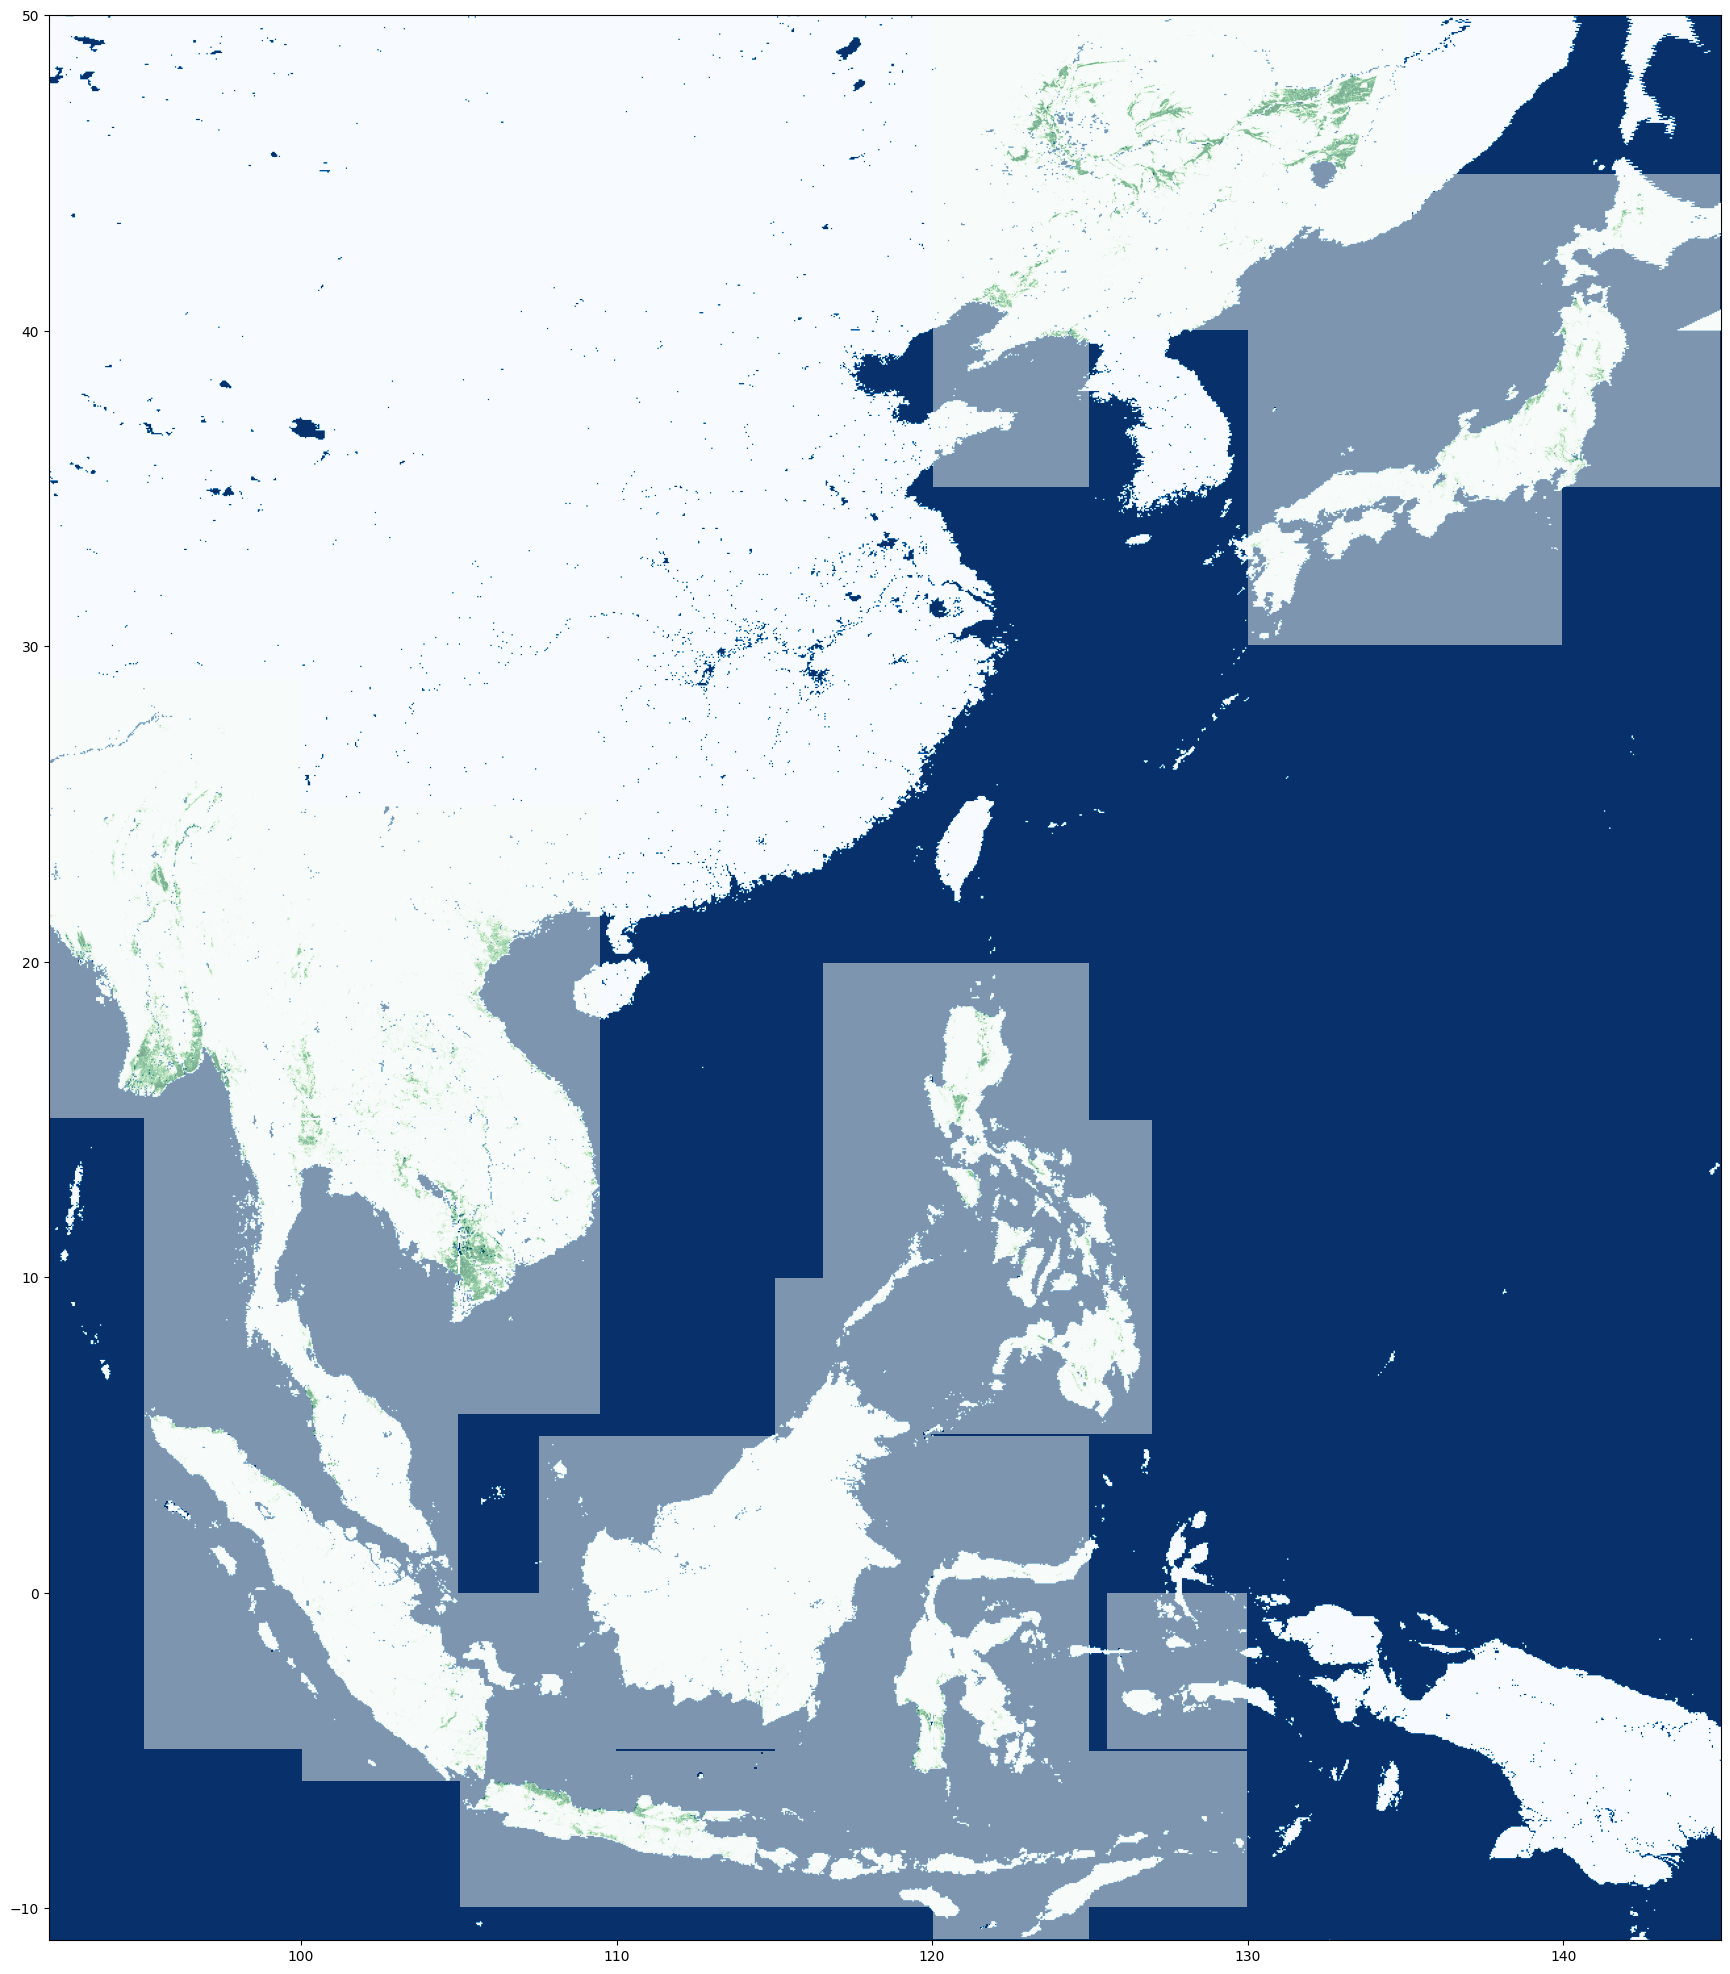

In [7]:
# Plot rice mask with water mask
rice_file = os.path.join(path, "Rice_map", "out.tif")
rice_map = rasterio.open(rice_file)

water = rasterio.open(os.path.join(path, "Asia", "water_mask.tif"))


fig, ax = plt.subplots(figsize=(60, 25))
rasterio.plot.show(water, ax=ax, cmap="Blues")
rasterio.plot.show(rice_map, ax=ax, alpha=0.5, cmap="Greens")

### Align rice map and crop model output (in bounds and resolution)

In [8]:
def crop_tiff(file_in, file_out, bound):
    """Crops .tiff file and writes new one

    Parameters:
    --------
        path_src: Callable[str]
            Source folder
        path_dest: Callable[Dict]
            Destination folder
        bound: Callable[Object]
            Transformation properties

    Returns:
    --------
        new cropped .tiff files
    """
    with rasterio.open(file_in) as src:
        out_image, out_transform = mask(src, [bound.poly], crop=True)
        # Create a new cropped raster to write to
        profile = src.profile
        profile.update(
            {
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
            }
        )

        with rasterio.open(file_out, "w", **profile) as dst:
            # Read the data and write it to the output raster
            dst.write(out_image)

In [9]:
def reshape_tiff(file_in, file_out, bound):
    """Reshapes .tiff file and writes new one

    Parameters:
    --------
        path_src: Callable[str]
            Source folder
        path_dest: Callable[Dict]
            Destination folder
        bound: Callable[Object]
            Transformation properties

    Returns:
    --------
        new cropped .tiff files
    """

    with rasterio.open(file_in) as src:
        # Create a new cropped raster to write to
        profile = src.profile
        profile.update(
            {"height": bound.height, "width": bound.width, "transform": bound.transform}
        )

        with rasterio.open(file_out, "w", **profile) as dst:
            # Read the data and write it to the output raster
            dst.write(src.read())

In [10]:
class crop_features:
    """Class holding features for cropping and reshape

    Returns:
    --------
        new object of the class
    """

    def __init__(self, path_border, path_grid):
        bounds = rasterio.open(path_border).bounds

        # Define coordinate bounds
        left = bounds.left
        top = bounds.top
        right = bounds.right
        bottom = bounds.bottom

        bbox = [left, bottom, right, top]

        res_x = rasterio.open(path_grid).transform[0]
        res_y = -rasterio.open(path_grid).transform[4]

        self.width = (right - left) / res_x
        self.height = (top - bottom) / res_y
        bbox_size = (self.height, self.width)

        self.transform = rasterio.transform.from_bounds(
            *bbox, width=bbox_size[1], height=bbox_size[0]
        )

        p1 = geometry.Point(left, bottom)
        p2 = geometry.Point(left, top)
        p3 = geometry.Point(right, top)
        p4 = geometry.Point(right, bottom)

        pointList = [p1, p2, p3, p4]
        self.poly = geometry.Polygon([i for i in pointList])

In [11]:
path_model = os.path.join(path_pics, "model_climate_lc", "changes_2028.tif")
file_step1 = rice_file[:-4] + "1.tif"
file_step2 = rice_file[:-4] + "2.tif"
file_step3 = rice_file[:-4] + "3.tif"

# New rice output (cropped)
bound = crop_features(path_model, rice_file)
crop_tiff(rice_file, file_step1, bound)

# New model output (cropped)
bound = crop_features(file_step1, file_step1)
crop_tiff(path_model, file_step2, bound)

# Reshape rice output
bound = crop_features(file_step1, file_step2)
reshape_tiff(file_step1, file_step3, bound)

<Axes: >

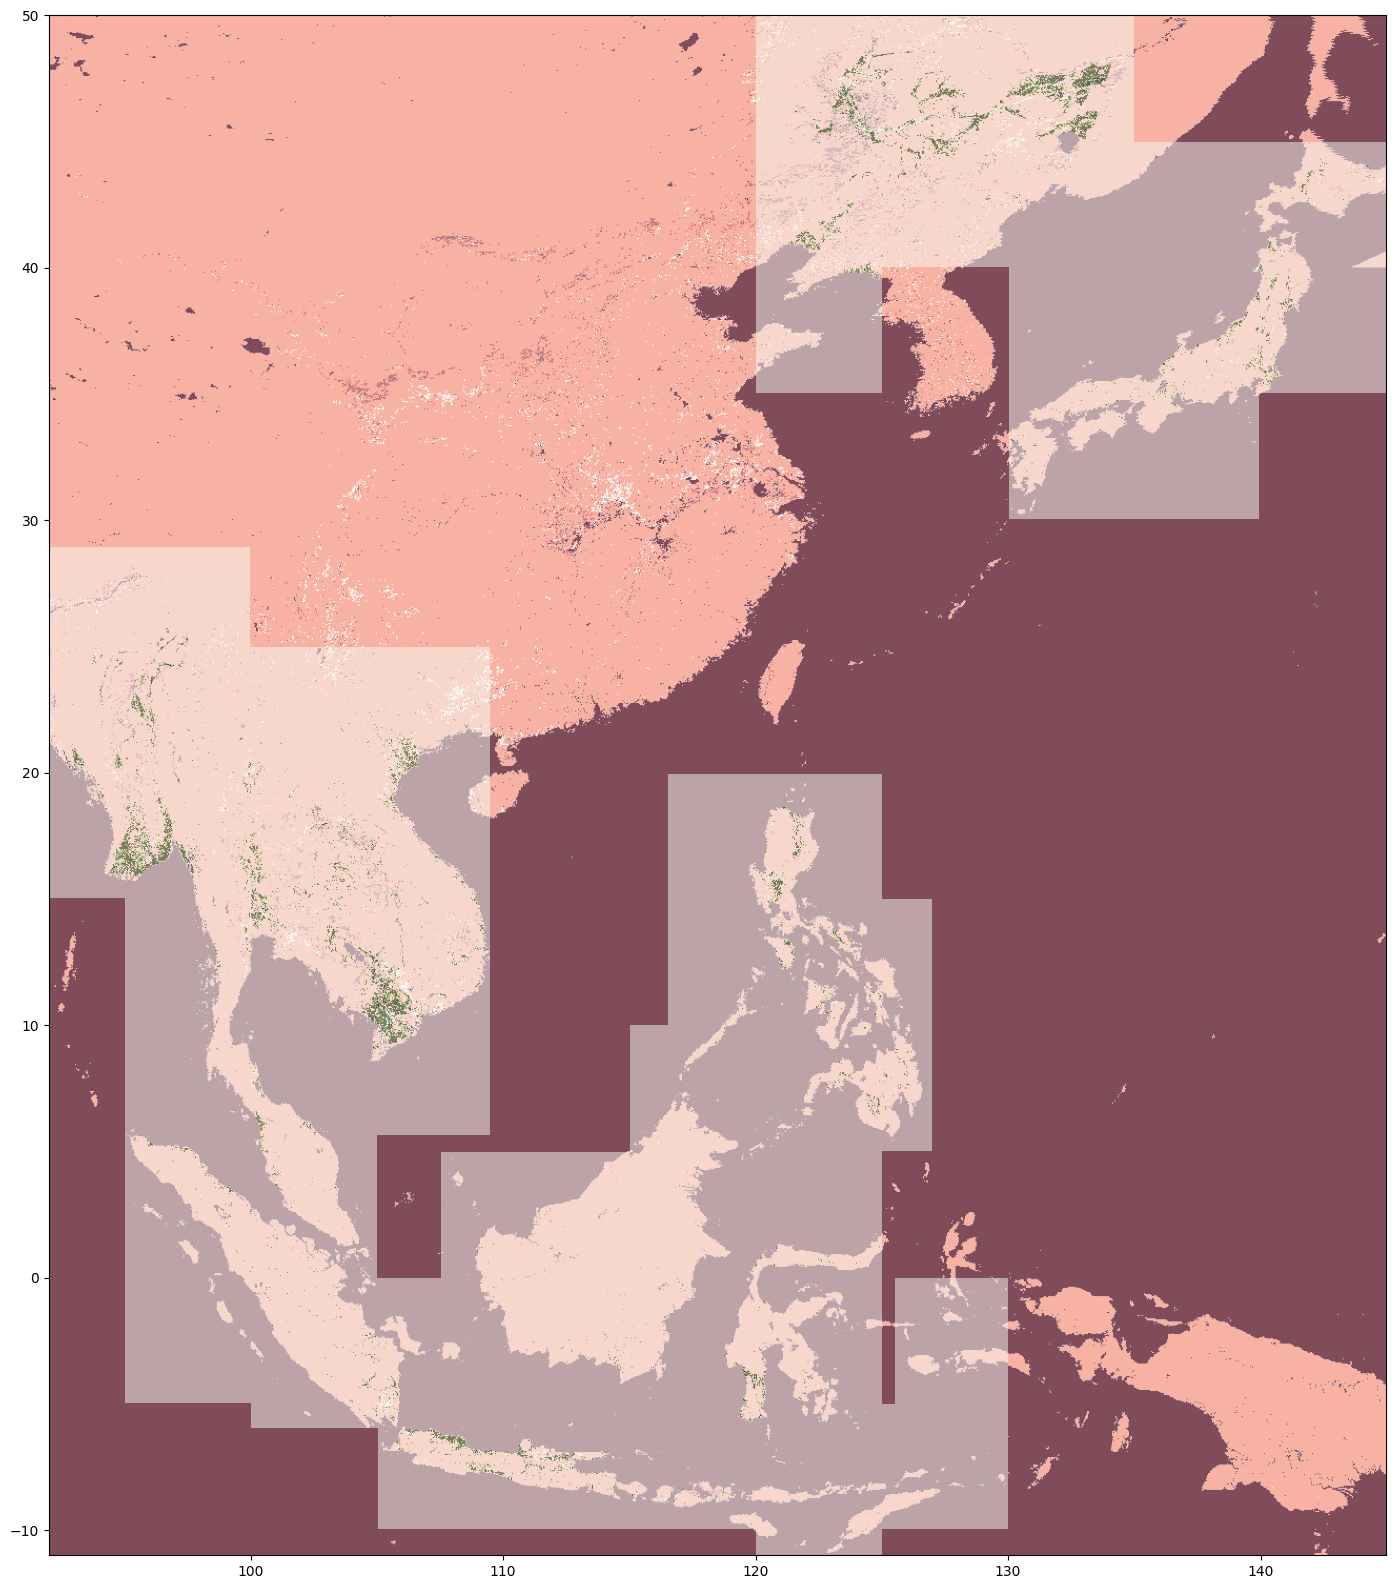

In [12]:
# Plot all together
rice_map = rasterio.open(file_step3)
model_map = rasterio.open(path_model)
water = rasterio.open(os.path.join(path, "Asia", "water_mask.tif"))

fig, ax = plt.subplots(figsize=(50, 20))
rasterio.plot.show(water, ax=ax, cmap="Blues")
rasterio.plot.show(model_map, ax=ax, alpha=0.5, cmap="Reds")
rasterio.plot.show(rice_map, ax=ax, alpha=0.5, cmap="Greens")

In [13]:
# Cut few extra pixels
model = rasterio.open(file_step2).read(1)[1:-1, 1:-1]
rice = rasterio.open(file_step3).read(1)
rice.shape == model.shape

True

In [14]:
# Create new tif with model output multiplied by rice mask
new_raster = rice * model

with rasterio.open(file_step3) as src:
    profile = src.profile

with rasterio.open(
    os.path.join(path_pics, "rice_climate_lc", "changes_rice.tif"), "w", **profile
) as dst:
    # Read the data and write it to the output raster
    dst.write(new_raster, 1)

values, counts_2018 = np.unique(new_raster, return_counts=True)
print(values, counts_2018)

[-3. -1.  0.  1.  3.] [   4237     279 1852482     530    3216]


In [15]:
# pay attention, the same data from tif show different unique values with same frequency
new_raster = rasterio.open(
    os.path.join(path_pics, "rice_climate_lc", "changes_rice.tif")
).read(1)
values, counts_2018 = np.unique(new_raster, return_counts=True)
print(values, counts_2018)

[  0   1   3 253 255] [1852482     530    3216    4237     279]


### Count risks withing country borders

In [6]:
country_names = [
    "Bangladesh",
    "Cambodia",
    "Japan",
    "Indonesia",
    "Lao PDR",
    "Malaysia",
    "Myanmar",
    "Philippines",
    "Korea",
    "Thailand",
    "Viet Nam",
]
prefixes = ["BGD", "KHM", "JPN", "IDN", "LAO", "MYS", "MMR", "PHL", "KOR", "THA", "VNM"]

### Country level negative change

In [24]:
for country in country_names:
    country_test = (
        rxr.open_rasterio(f"/app/data/03-results/basic_{country}.tif").to_numpy().squeeze()
    )
    country_proba = (
        rxr.open_rasterio(
            f"/app/data/03-results/model_climate_lc_new/changes_proba_2028_{country}.tif"
        )
        .to_numpy()
        .squeeze()
    )
    # Creating the masks
    mask1 = country_test == 1
    mask2 = country_proba + country_test < 0.2
    mask3 = country_test == 0
    mask4 = country_proba + country_test > 0.8

    # Get the number of elements where both conditions are met
    neg_trend_count = (mask1 & mask2).sum()
    pos_trend_count = (mask3 & mask4).sum()

    # Calculate the proportion relative to the number of cases where y_test is 1
    if mask1.sum() != 0:
        neg_trend = (- neg_trend_count ) / mask1.sum()  * 100
        print(
            f"Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: {neg_trend} % for {country}"
        )
        over_trend = (- neg_trend_count + pos_trend_count) / mask1.sum()  * 100
        print(
            f"Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: {over_trend} % for {country}"
        )
    else:
        print("No elements in y_test are 1, cannot compute proportion.")

Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: -8.019774787146389 % for Bangladesh
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: 6.454270804723977 % for Bangladesh
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: -4.279982166740972 % for Cambodia
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: 10.521622826571555 % for Cambodia
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: -12.358757062146893 % for Japan
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: 0.3531073446327684 % for Japan
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: -17.346938775510203 % for Indonesia
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: -1.7346938775510203 % for Indonesia
Proportion of negative trends where y_test is 1 and prediction_prob < 0.5: -9.195402298850574 % for Lao PDR
Proportion of nega

In [17]:
def crop_raster(file_name, source_tif, count, shapes, path):
    """Crops .tif file

    Parameters:
    --------
        file_name: str
            New file name
        source_tif: str
            Original tif file to crop
        count: int
            Number of bands
        shapes:
            Array of shapes defining country border
        path: str
            Path to the folder with source GeoTiff file

    Returns:
    --------
        Saves the results to .tif file
    """
    # Random source file to copy geodata for creating GeoTiff
    fn = os.listdir(os.path.join(path, "SEAsia", "Climate_future", ""))[-1]

    template = rasterio.open(os.path.join(path, "SEAsia", "Climate_future", fn))

    # Crop the tif
    with rasterio.open(source_tif) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = template.meta

    out_meta.update(
        {
            "driver": "GTiff",
            "count": count,
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
        }
    )
    # Write new tif
    with rasterio.open(file_name, "w", **out_meta) as dest:
        dest.write(out_image)

In [18]:
def crop_country(prefixes, country_names, path, path_pics):
    """Crops .tifs with changes up to country

    Parameters:
    --------
        model_name: str
            Model name as it is spelled in corresponding folder
        prefixes: List[str]
            Short country names used in shapefiles
        country_name: List[str]
            Normal spelling of country
        path: str
            Path to the folder with source GeoTiff file
        path_pics: str
            Path to save the new pic


    Returns:
    --------
        Saves the results to 3.tif files for every country
    """
    os.makedirs(os.path.join(path_pics, "rice_climate_lc"), exist_ok=True)
    for prefix, country_name in zip(prefixes, country_names):
        # Load administrative borders
        with fiona.open(
            os.path.join(path, "boundary", f"gadm41_{prefix}_0.shx"), "r"
        ) as sf:
            shapes = [feature["geometry"] for feature in sf]

        # Crop the country pic with changes
        crop_raster(
            os.path.join(path_pics, "rice_climate_lc", f"rice_2018_{country_name}.tif"),
            os.path.join(path_pics, "rice_climate_lc", "rice_2018.tif"),
            1,
            shapes,
            path,
        )

In [19]:
# Run this cell for --changes_rice file and --rice_2018 (replace IN crop_country function and run again)
crop_country(prefixes, country_names, path, path_pics)

In [20]:
positive_changes = dict.fromkeys(prefixes)  # crop lands appeared
negative_changes = dict.fromkeys(prefixes)  # crop lands disappeared

for prefix, country_name in zip(prefixes, country_names):
    print(country_name)

    # Load administrative borders
    with fiona.open(
        os.path.join(path, "boundary", f"gadm41_{prefix}_0.shx"), "r"
    ) as sf:
        shapes = [feature["geometry"] for feature in sf]
    patches = [
        PolygonPatch(shape, edgecolor="black", facecolor="none", linewidth=1)
        for shape in shapes
    ]

    basic = rasterio.open(
        os.path.join(path_pics, "rice_climate_lc", f"rice_2018_{country_name}.tif")
    )
    values_2018, counts_2018 = np.unique(basic.read(), return_counts=True)
    print(values_2018, counts_2018)

    changes = rasterio.open(
        os.path.join(path_pics, "rice_climate_lc", f"changes_rice_{country_name}.tif")
    )
    values, counts = np.unique(changes.read(), return_counts=True)
    print(values, counts)

    # dissapeared: 1-->255
    if len(np.where(values == 255)[0]) != 0 and len(np.where(values_2018 == 1)[0]) != 0:
        idx = np.where(values == 255)[0][0]
        idx_2018 = np.where(values_2018 == 1)[0][0]
        negative_changes[prefix] = np.round(
            counts[idx] / counts_2018[idx_2018] * 100, 1
        )
    else:
        negative_changes[prefix] = 0
    # positive_changes[prefix] = np.round(counts[1]/counts_2018[1]*100, 1)

Bangladesh
[0. 1. 3.] [ 799    2 1487]
[0. 1. 3.] [ 798    3 1487]
Cambodia
[0. 1. 3.] [7961  756 6131]
[  0.   1.   3. 255.] [8132  579 6131    6]
Japan
[0. 1. 3.] [ 17822    346 254796]
[  0.   1.   3. 255.] [ 20563    538 251855      8]
Indonesia
[3.] [2212]
[  0.   1.   3. 255.] [ 66257   1072 386093     38]
Lao PDR
[0. 1. 3.] [11228    97 26531]
[  0.   1.   3. 255.] [11228    96 26531     1]
Malaysia
[0. 1. 3.] [  854    43 15151]
[  0.   1.   3. 255.] [15337   110 59128     1]
Myanmar
[0. 1. 3.] [31962  1626 69487]
[  0.   1.   3. 255.] [31914  1654 69487    20]
Philippines
[0. 1. 3.] [13394   543 70409]
[  0.   1.   3. 255.] [13588   540 78132     8]
Korea
[0. 1. 3.] [ 5669   147 17459]
[0. 3.] [   11 23264]
Thailand
[0. 1. 3.] [23797  1010 44793]
[  0.   1.   3. 255.] [24116   788 46691     5]
Viet Nam
[0. 1. 3.] [14951  1185 47761]
[  0.   1.   3. 255.] [14978  1052 47761   106]


In [21]:
negative_changes

{'BGD': 0,
 'KHM': 0.8,
 'JPN': 2.3,
 'IDN': 0,
 'LAO': 1.0,
 'MYS': 2.3,
 'MMR': 1.2,
 'PHL': 1.5,
 'KOR': 0,
 'THA': 0.5,
 'VNM': 8.9}